# <a id='toc1_'></a>[Ticket Entry Approved/Denied Analysis](#toc0_)

**Icey Xue**  
Date: 02/24/2024

**Table of contents**<a id='toc0_'></a>    
- [Ticket Entry Approved/Denied Analysis](#toc1_)    
  - [0  Data Preparation](#toc1_1_)    
    - [Data Dictionary:](#toc1_1_1_)    
  - [1  Data Exploration and Visualization](#toc1_2_)    
    - [Distributions:](#toc1_2_1_)    
    - [Correlations:](#toc1_2_2_)    
  - [2  Data Preparation: Fill NaNs with KNN](#toc1_3_)    
  - [3  PCA Analysis](#toc1_4_)    
    - [1) Base Model](#toc1_4_1_)    
    - [2) Lasso Model](#toc1_4_2_)    
    - [3) PCA](#toc1_4_3_)    
    - [*Result Analysis:](#toc1_4_4_)    
  - [4  Decision Tree Analysis](#toc1_5_)    
    - [*Result Analysis:](#toc1_5_1_)    
  - [5  K Means Clustering using Age and Price](#toc1_6_)    
      - [*Result Analysis:](#toc1_6_1_1_)    
  - [6  Findings and Conclusions](#toc1_7_)    
    - [1) Entry Prediction](#toc1_7_1_)    
    - [2) K-Means Clustering](#toc1_7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[0  Data Preparation](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("Event_entry.csv")
data

,Entry,TicketClass,Sex,Age,Price,Order,Name,Ticket Number,Bank Balance
0,0,3,male,22.0,7,1,"Braund, Mr. Owen Harris",648155,74389
1,1,1,female,38.0,71,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",119239,94932
2,1,3,female,26.0,8,3,"Heikkinen, Miss. Laina",411408,26146
3,1,1,female,35.0,53,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",530093,35627
4,0,3,male,35.0,8,5,"Allen, Mr. William Henry",510583,60457
...,...,...,...,...,...,...,...,...,...
864,0,2,male,24.0,13,865,"Gill, Mr. John William",305015,87301
865,1,2,female,42.0,13,866,"Bystrom, Mrs. (Karolina)",459167,48146
866,1,2,female,27.0,14,867,"Duran y More, Miss. Asuncion",508948,60741
867,0,1,male,31.0,50,868,"Roebling, Mr. Washington Augustus II",942774,19589


### <a id='toc1_1_1_'></a>[Data Dictionary:](#toc0_)

| Name           | Description                           |
|----------------|---------------------------------------|
| Order          | Order of buying the tickets           |
| Entry          | 0 is denied, 1 is approved            |
| Ticket class   | 1, 2, 3 different types of tickets    |
| Sex            | Gender                                |
| Age            | Age                                   |
| Price          | Price of Ticket                       |
| Name           | Name of buyer                         |
| Ticket         | Ticket number                         |
| Bank Balance   | Bank balance of ticket buyer          |

> Note that 'Order' is the primary key for this table.

## <a id='toc1_2_'></a>[1  Data Exploration and Visualization](#toc0_)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869 entries, 0 to 868
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Entry          869 non-null    int64  
 1   TicketClass    869 non-null    int64  
 2   Sex            869 non-null    object 
 3   Age            694 non-null    float64
 4   Price          869 non-null    int64  
 5   Order          869 non-null    int64  
 6   Name           869 non-null    object 
 7   Ticket Number  869 non-null    int64  
 8   Bank Balance   869 non-null    int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 61.2+ KB


> Only the 'Age' column has null values.

In [4]:
data.describe()

,Entry,TicketClass,Age,Price,Order,Ticket Number,Bank Balance
count,869.000000,869.000000,694.000000,869.000000,869.000000,869.000000,869.000000
mean,0.384350,2.307250,29.732233,32.594937,435.000000,479171.174914,50269.125432
std,0.486721,0.836222,14.599438,50.186076,251.002988,286307.965548,28158.833520
min,0.000000,1.000000,0.420000,0.000000,1.000000,1222.000000,108.000000
25%,0.000000,2.000000,20.125000,8.000000,218.000000,228933.000000,27438.000000
50%,0.000000,3.000000,28.000000,14.000000,435.000000,453195.000000,50588.000000
75%,1.000000,3.000000,38.000000,31.000000,652.000000,722522.000000,73549.000000
max,1.000000,3.000000,80.000000,512.000000,869.000000,999921.000000,99548.000000


### <a id='toc1_2_1_'></a>[Distributions:](#toc0_)

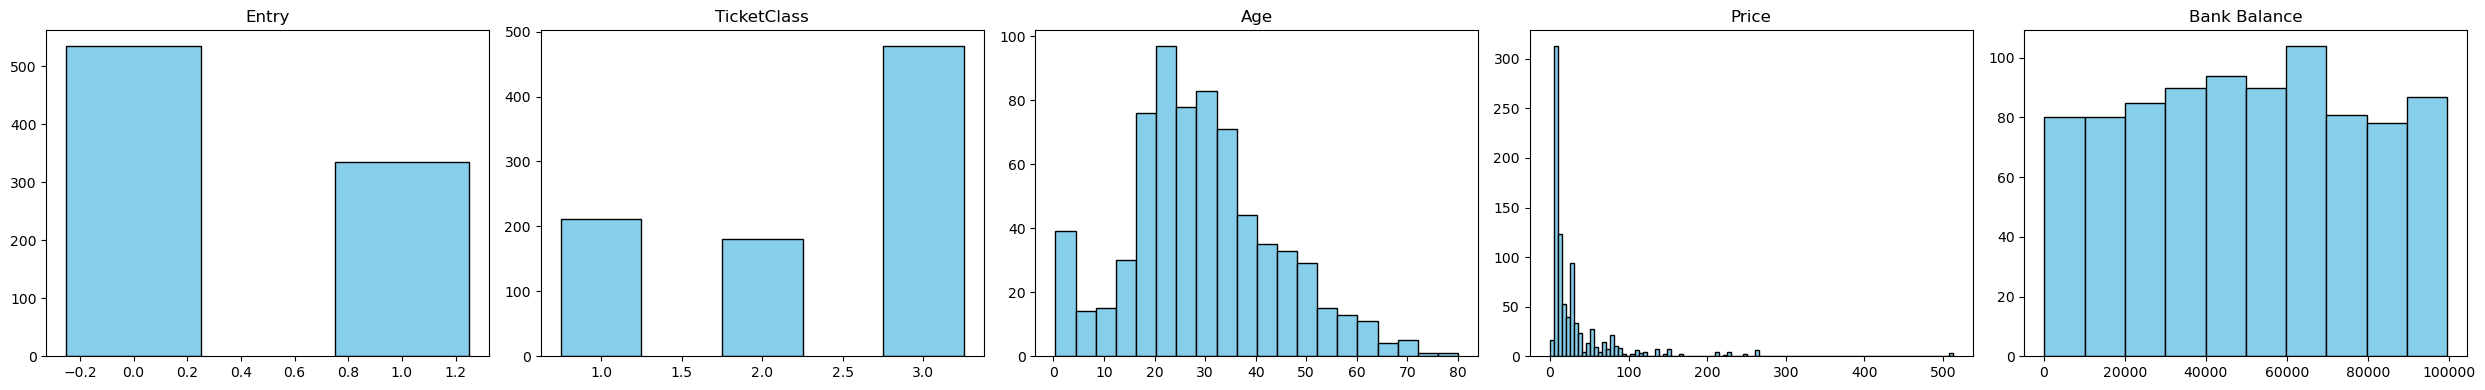

In [37]:
fig, axs = plt.subplots(1, 5, figsize=(25, 4))

plot_variables = ['Entry', 'TicketClass', 'Age', 'Price', 'Bank Balance']
bin_sizes = [None, None, 20, 100, 10]  # Assuming you want to specify bin sizes for histograms

for ii, var in enumerate(plot_variables):
    if var in ['Age', 'Price', 'Bank Balance']:  # continuous variables
        # plot histogram
        axs[ii].hist(data[var], bins=bin_sizes[ii], color='skyblue', edgecolor='black')
    else: # categorical variables
        # plot bar plot 
        counts = data[var].value_counts()
        axs[ii].bar(counts.index, counts.values, width=0.5, color='skyblue', edgecolor='black')
    
    axs[ii].set_title(var)
    #axs[ii].tick_params(axis='x', rotation=45)  # Rotate x labels for better readability

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


> Note: 
>> 1. Drop Price outlier in future data processing;  
>> 2. Skewed distribution for most X variables, consider using *RobustScaler* for scaling.  

> **Findings:**
> - TicketClass = 3 is the most common (lowest class);  
> - Age distribution is right skewed;  
> - Price is right skewed also and condensed in [0, 100];  
> - Bank Balance is almost uniform.

### <a id='toc1_2_2_'></a>[Correlations:](#toc0_)

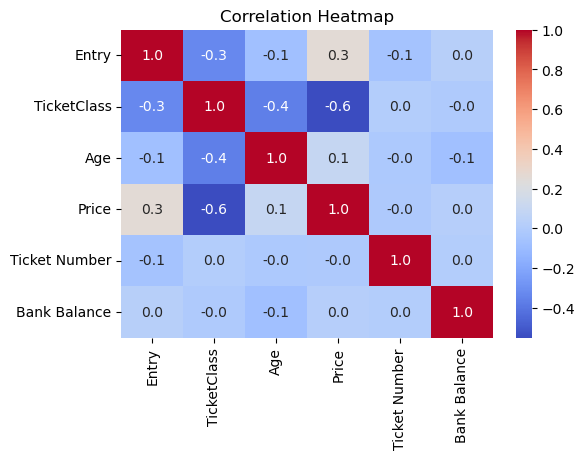

In [95]:
plt.figure(figsize=(6, 4))
sns.heatmap(data.drop(['Order'], axis=1).corr(), annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
sns.pairplot(data, x_vars=['TV', 'Radio','Newspaper'], 
             y_vars='Sales', size=4, aspect=1, kind='scatter')
plt.show()

> corr(Price, Ticket Class) = -0.6: The larger the Class number, the cheaper the price:  
    >> Class=3 is the cheapest

> corr(Age, Ticket Class) = -0.4: The older the customer, the more likely their tickets to be better class

> corr(Price, Entry) = 0.3: The higher the ticket price, the more likely to be approved

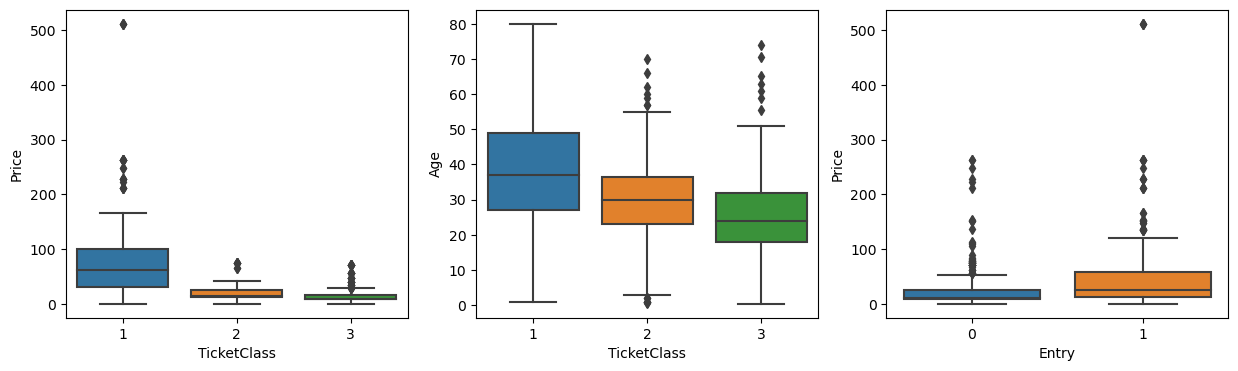

In [22]:
# Further investigate in these correlations:

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.boxplot(x='TicketClass', y='Price', data=data, ax=axs[0])
sns.boxplot(x='TicketClass', y='Age', data=data, ax=axs[1])
sns.boxplot(x='Entry', y='Price', data=data, ax=axs[2])

plt.show()

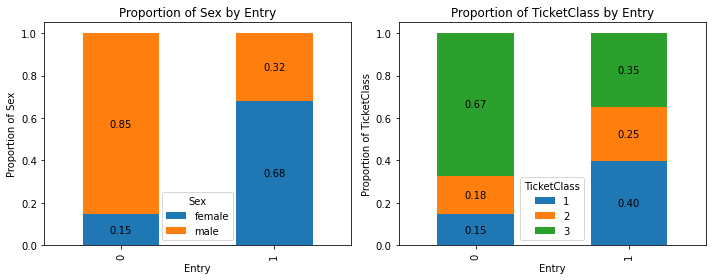

In [3]:
# Entry X categorical variables
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_variables = ['Sex','TicketClass']

# Calculate the proportion of 2 categorical variables within each entry and plot stacked bar plots
for ii, var in enumerate(plot_variables):
    entry_var = data.groupby(['Entry', var]).size().unstack(var, fill_value=0)
    prop_entry_var = entry_var.div(entry_var.sum(axis=1), axis=0)
    
    axs[ii].set_xlabel('Entry')
    axs[ii].set_ylabel('Proportion of ' + var)
    axs[ii].set_title('Proportion of ' + var + ' by Entry')

    bars = prop_entry_var.plot(kind='bar', stacked=True, ax=axs[ii])
    for bar in bars.containers:
        axs[ii].bar_label(bar, label_type='center', fmt='%.2f')

plt.tight_layout()
plt.show() 

> Seems like these categotical variables influence the entry a lot.

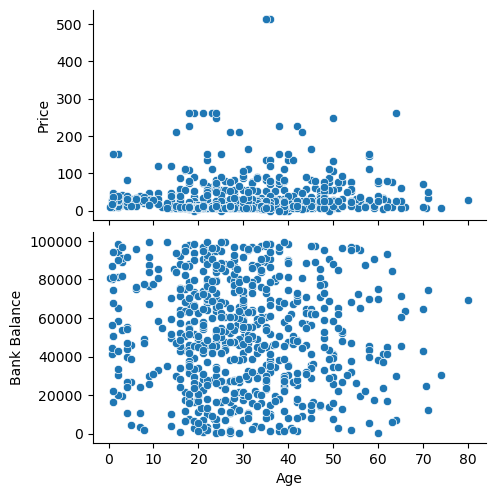

In [46]:
# Age X (Price, Bank Balance):
sns.pairplot(data, x_vars='Age', 
             y_vars=['Price','Bank Balance'], size=2.5, aspect=2, kind='scatter')
plt.show()

> Correlation not obvious.

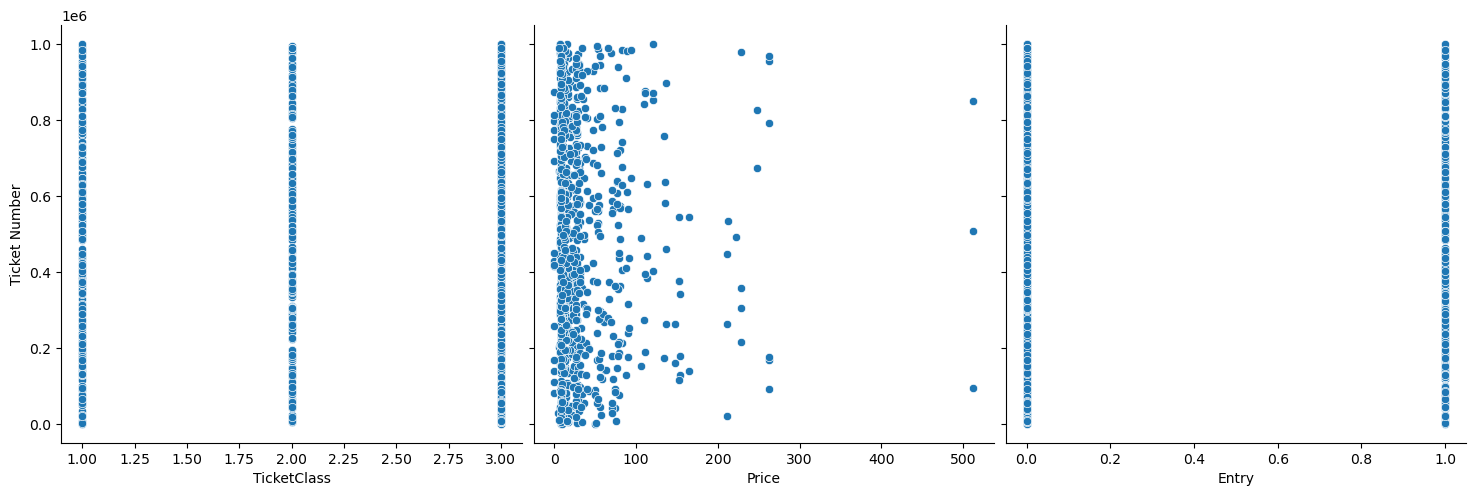

In [93]:
# Because we wanna keep as more X varaibles as possile,
# try to find the meaning of Ticket Number
sns.pairplot(data, x_vars=['TicketClass','Price','Entry'], 
             y_vars='Ticket Number', size=5, aspect=1, kind='scatter')
plt.show()

> No obvious pattern, considering not including Ticket Number in modeling.

In [4]:
# Create a 'Married' column using 'Name'
names = data[['Name']]

# Extract their honorific
import re
pattern = r'\b[A-Z][a-z]+\.'
names['Honorific'] = names['Name'].apply(lambda x: re.search(pattern, x).group(0))
names['Honorific'].value_counts()

Mr.          506
Miss.        178
Mrs.         120
Master.       39
Dr.            7
Rev.           5
Mlle.          2
Major.         2
Col.           2
Countess.      1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: Honorific, dtype: int64

In [5]:
# Replace 'Master.','Major.' with 'Ms.';
# Replace 'Mlle.','Ms.' with 'Miss.';
# Replace 'Mme.' with 'Mrs.'
# [Gender Neutral: 'Dr.','Rev.','Col.','Capt.']
honorific_map = {
    'Mr.':'Mr',
    'Mrs.':'Mrs',
    'Miss.':'Miss',
    'Master.': 'Mr',
    'Major.': 'Mr',
    'Sir.': 'Mr',
    'Mlle.': 'Miss',
    'Ms.': 'Miss',
    'Lady.': 'Miss',
    'Mme.': 'Mrs',
    'Countess.': 'Mrs'
}

# Use map with the flattened dictionary
names['Honorific'] = names['Honorific'].map(honorific_map)
print(names['Honorific'].value_counts(), "\n")
print(names['Honorific'].isna().sum())

Mr      548
Miss    182
Mrs     122
Name: Honorific, dtype: int64 

17


In [6]:
# Drop those NaNs
data_re = pd.concat([data.drop(['Name'], axis=1), names[['Honorific']]], axis=1)
data_re.dropna(subset=['Honorific'], axis=0, inplace=True)

data_re.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852 entries, 0 to 868
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Entry          852 non-null    int64  
 1   TicketClass    852 non-null    int64  
 2   Sex            852 non-null    object 
 3   Age            678 non-null    float64
 4   Price          852 non-null    int64  
 5   Order          852 non-null    int64  
 6   Ticket Number  852 non-null    int64  
 7   Bank Balance   852 non-null    int64  
 8   Honorific      852 non-null    object 
dtypes: float64(1), int64(6), object(2)
memory usage: 66.6+ KB


## <a id='toc1_3_'></a>[2  Data Preparation: Fill NaNs with KNN](#toc0_)

In [154]:
data_re.isna().sum()

Entry              0
TicketClass        0
Sex                0
Age              174
Price              0
Order              0
Ticket Number      0
Bank Balance       0
Honorific          0
dtype: int64

> Next: Fill Age NaNs using KNN
>> Varaibles for determing Neighbors: (profile related variables)
>> - TicketClass, Sex, Price, Bank Balance

In [7]:
from sklearn.impute import KNNImputer

sex_dummies = pd.get_dummies(data_re['Sex'], drop_first=True)
honor_dummies = pd.get_dummies(data_re['Honorific'], drop_first=False)['Miss'] # only keep the differentiator for Miss and Mrs coz Sex already distinguishes Mr from them
knn_vars = data_re[['Age','TicketClass','Price', 'Bank Balance']]
knn_vars = pd.concat([knn_vars, sex_dummies, honor_dummies], axis=1)

knn_sclaed = pd.DataFrame(MinMaxScaler().fit_transform(knn_vars.drop(['Age'], axis=1)), columns = knn_vars.columns[1:])

imputer = KNNImputer(n_neighbors=3)
knn_filled = pd.DataFrame(imputer.fit_transform(pd.concat([knn_vars['Age'], knn_sclaed], axis=1)),columns = knn_vars.columns)

knn_filled.isna().any()

Age             False
TicketClass     False
Price           False
Bank Balance    False
male            False
Miss            False
dtype: bool

(array([ 39.,  16.,  18.,  43.,  87., 110., 111., 116., 100.,  70.,  42.,
         40.,  30.,  15.,  11.,  11.,   4.,   4.,   1.,   1.]),
 array([ 0.42 ,  4.399,  8.378, 12.357, 16.336, 20.315, 24.294, 28.273,
        32.252, 36.231, 40.21 , 44.189, 48.168, 52.147, 56.126, 60.105,
        64.084, 68.063, 72.042, 76.021, 80.   ]),
 <BarContainer object of 20 artists>)

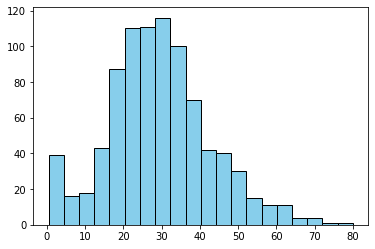

In [8]:
plt.hist(knn_filled['Age'], bins=20, color='skyblue', edgecolor='black')

> The distribution pattern looks similar to before filled pattern.

In [9]:
# Merge Filled Age into original data
data_new = data_re.drop(['Sex','Honorific'], axis=1)
data_new = pd.concat([data_new, sex_dummies, honor_dummies], axis=1)
data_new['Age'] = knn_filled['Age']
data_new.isna().any()

Entry            False
TicketClass      False
Age              False
Price            False
Order            False
Ticket Number    False
Bank Balance     False
male             False
Miss             False
dtype: bool

In [10]:
# Drop the Price outliers
data_new = data_new.query("Price < 400") # from the boxplot
data_new = data_new.reset_index(drop=True)
data_new.shape

(849, 9)

In [11]:
# Final dataset for modeling:
data_new

,Entry,TicketClass,Age,Price,Order,Ticket Number,Bank Balance,male,Miss
0,0,3,22.000000,7,1,648155,74389,1,0
1,1,1,38.000000,71,2,119239,94932,0,0
2,1,3,26.000000,8,3,411408,26146,0,1
3,1,1,35.000000,53,4,530093,35627,0,0
4,0,3,35.000000,8,5,510583,60457,1,0
...,...,...,...,...,...,...,...,...,...
844,0,2,36.333333,13,865,305015,87301,1,0
845,1,2,48.333333,13,866,459167,48146,0,0
846,1,2,33.333333,14,867,508948,60741,0,1
847,0,1,17.333333,50,868,942774,19589,1,0


## <a id='toc1_4_'></a>[3  PCA Analysis](#toc0_)

In [17]:
# Define Logistic Regression report function
def GetReport(y_test, y_pred):
    print(classification_report(y_test, y_pred))

    print("Accuracy:       ", accuracy_score(y_test, y_pred))
    print("OOS R-square:  ", r2_score(y_test, y_pred))
    print("OOS RMSE:       ", np.sqrt(mean_squared_error(y_test, y_pred)))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### <a id='toc1_4_1_'></a>[1) Base Model](#toc0_)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       108
           1       0.71      0.65      0.68        62

    accuracy                           0.78       170
   macro avg       0.76      0.75      0.75       170
weighted avg       0.77      0.78      0.77       170

Accuracy:        0.7764705882352941
OOS R-square:   0.03524492234169663
OOS RMSE:        0.47278897170376755


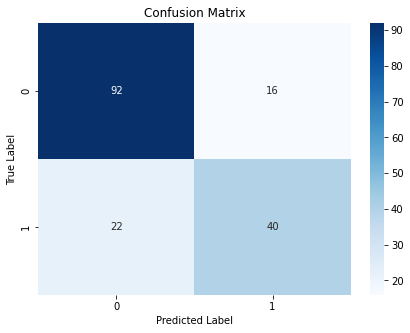

In [18]:
X = data_new.drop(['Entry','Order','Ticket Number'], axis=1)
y = data_new['Entry']

X_scaled = RobustScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=111)

lr_model = LogisticRegression().fit(X_train, y_train)
y_pred_base = lr_model.predict(X_test)

GetReport(y_test, y_pred_base)

**Comparison: using StandardScaler**

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       108
           1       0.71      0.65      0.68        62

    accuracy                           0.78       170
   macro avg       0.76      0.75      0.75       170
weighted avg       0.77      0.78      0.77       170

Accuracy:        0.7764705882352941
OOS R-square:   0.03524492234169663
OOS RMSE:        0.47278897170376755


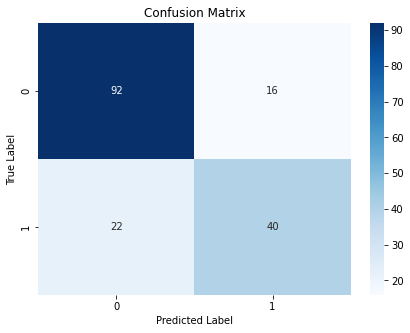

In [19]:
X_scaled_std = StandardScaler().fit_transform(X)

X_train_std, X_test_std, y_train, y_test = train_test_split(X_scaled_std, y, test_size=0.2, random_state=111)

lr_model_std = LogisticRegression().fit(X_train_std, y_train)
y_pred_base_std = lr_model_std.predict(X_test_std)

GetReport(y_test, y_pred_base_std)

In [103]:
abs(lr_model.coef_ - lr_model_std.coef_)

array([[0.15446548, 0.01185347, 0.01391227, 0.08601137, 1.28181877,
        0.02932269]])

> Using RobustScaler or StandardScaler doesn't make any difference in the model prediction performance.  
> Stick to RobustScaler for further modeling.

### <a id='toc1_4_2_'></a>[2) Lasso Model](#toc0_)

Best alpha:  0.004291934260128779


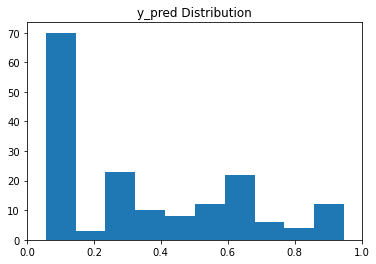

Number of selected variables: 4
Index(['TicketClass', 'Age', 'Bank Balance', 'male'], dtype='object') 

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       108
           1       0.71      0.65      0.68        62

    accuracy                           0.78       170
   macro avg       0.76      0.75      0.75       170
weighted avg       0.77      0.78      0.77       170

Accuracy:        0.7764705882352941
OOS R-square:   0.03524492234169663
OOS RMSE:        0.47278897170376755


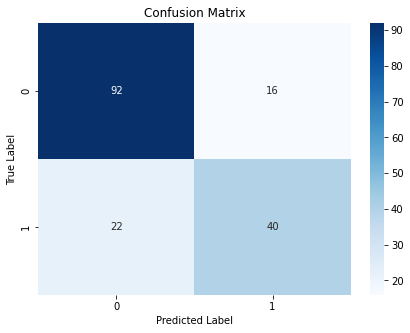

In [28]:
alphas = np.logspace(-4, 0, 50)

lasso_model = LassoCV(alphas=alphas, cv=10, max_iter=10000,)
lasso_model.fit(X_train, y_train)

print("Best alpha: ", lasso_model.alpha_)

y_pred_lasso = lasso_model.predict(X_test)

plt.hist(y_pred_lasso)
plt.xlim(0, 1)
plt.title("y_pred Distribution")
plt.show()

y_pred_lasso_bi = (y_pred_lasso > 0.5).astype(int)

print("Number of selected variables:", len(X.columns[lasso_model.coef_ != 0]))
print(X.columns[lasso_model.coef_ != 0], "\n") # selected variables

GetReport(y_test, y_pred_lasso_bi)

In [110]:
abs(lr_model.coef_ - lasso_model.coef_)

array([[0.83152449, 0.11857742, 0.00822068, 0.21117232, 2.11796177,
        0.0396915 ]])

### <a id='toc1_4_3_'></a>[3) PCA](#toc0_)

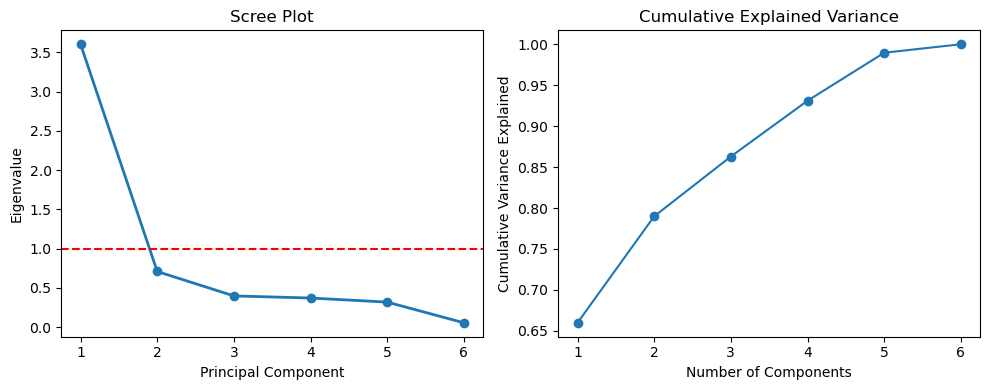

In [94]:
# Draw Scree Plot & Variance Explained Plot for further interpretations
pca = PCA().fit(X_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

eigenvalues = pca.explained_variance_
ax1.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', linewidth=2)
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Eigenvalue')
ax1.axhline(y=1, color='red', linestyle='--')  # horizontal "elbow" cutoff criterion
ax1.set_xticks(range(1, len(eigenvalues) + 1))

ax2.plot(range(1, len(np.cumsum(pca.explained_variance_ratio_)) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
ax2.set_title('Cumulative Explained Variance')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained')
ax2.set_xticks(range(1, len(np.cumsum(pca.explained_variance_ratio_)) + 1))

plt.tight_layout()
plt.show()

In [20]:
# Define PCA + Logistic Regression function for different dimension level
def PCA_LR(n, X, y):
    X_pca = PCA(n_components=n).fit_transform(X)
        
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=111)

    lr_model = LogisticRegression().fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)

    GetReport(y_test, y_pred)

N_Components =  2 

              precision    recall  f1-score   support

           0       0.66      0.92      0.77       108
           1       0.55      0.18      0.27        62

    accuracy                           0.65       170
   macro avg       0.60      0.55      0.52       170
weighted avg       0.62      0.65      0.59       170

Accuracy:        0.6470588235294118
OOS R-square:   -0.5232974910394264
OOS RMSE:        0.5940885257860046


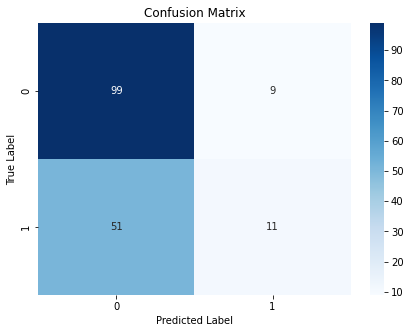

N_Components =  4 

              precision    recall  f1-score   support

           0       0.68      0.87      0.76       108
           1       0.55      0.27      0.37        62

    accuracy                           0.65       170
   macro avg       0.61      0.57      0.56       170
weighted avg       0.63      0.65      0.62       170

Accuracy:        0.6529411764705882
OOS R-square:   -0.4979091995221028
OOS RMSE:        0.5891169862849074


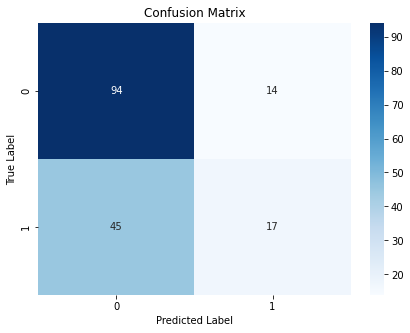

N_Components =  6 

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       108
           1       0.71      0.65      0.68        62

    accuracy                           0.78       170
   macro avg       0.76      0.75      0.75       170
weighted avg       0.77      0.78      0.77       170

Accuracy:        0.7764705882352941
OOS R-square:   0.03524492234169663
OOS RMSE:        0.47278897170376755


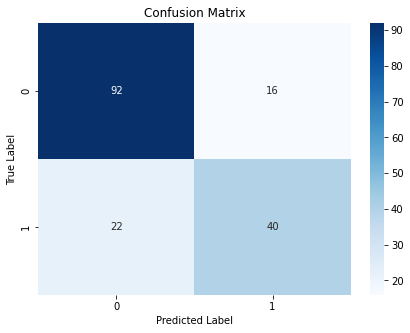

In [21]:
for nn in [2, 4, 6]:
    print("N_Components = ", nn, "\n")
    PCA_LR(nn, X_scaled, y)
    print("============================================================")

### <a id='toc1_4_4_'></a>[*Result Analysis:](#toc0_)
| Metric       | Base LR | Lasso LR | PCA(n=2) LR | PCA(n=4) LR | PCA(n=6) LR |
|--------------|---------|----------|-------------|-------------|-------------|
| Accuracy     | 0.776   | 0.776    | 0.647       | 0.652       | 0.776       |
| OOS R-square | 0.035   | 0.035    | -0.523      | -0.497      | 0.035       |
| OOS RMSE     | 0.472   | 0.472    | 0.594       | 0.589       | 0.472       |

> Note that the Base Model, Lasso Model and PCA(n=6) Model have the exactly same prediction performance.  


> **Model Performance Comparison:**  
> Comparing Accuracy, OOS R-square, and OOS RMSE, we can see that the prediction performance:  
>> <mark>Base LR **=** Lasso LR **=** PCA(n=6) LR **>** PCA(n=4) LR **>** PCA(n=2) LR</mark>

> **Explanation:**   
> 1. Base Model, Lasso Model and PCA(n=6) Model have the exactly same prediction performance:
>    - Since the Base Model only has 6 variables, after PCA(n=6), the 6 Principal Components  has the exact same information as the Base model's variables. The models will be the same for sure.  
>    - Lasso CV chose 4 X variables that are statistically significant for explaining y at alpha=0.00429. But the model prediction performance is the same, probably because the regularization applied by the Lasso model might not be leading to the omission of any important features, or the original feature set does not contain significant multicollinearity or irrelevant features that Lasso would typically remove.  

> 2. When decreasing PCA dimension, model performance is harmed:  
>    - Too less components number can severely harms the model performance, causing the OOS R-square to be negative.  
>    - The more dimensions PCA reduces, the more significant information that is necessary for the logistic regression model to make accurate predictions is omitted.  
>    - This can also be proved by the Cumulative Variance Explained Plot, where we can see as the dimension increases, the more variance the dimensions explained.  

To sum up, PCA generally reduces accuracy when severely reducing the variables dimension.  
But the computation for PCA is much lighter, which is a tradeoff to consider while building models in real life.

## <a id='toc1_5_'></a>[4  Decision Tree Analysis](#toc0_)

Using Gini criterion: 

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       108
           1       0.58      0.63      0.60        62

    accuracy                           0.70       170
   macro avg       0.68      0.68      0.68       170
weighted avg       0.71      0.70      0.70       170

Accuracy:        0.7
OOS R-square:   -0.2948028673835126
OOS RMSE:        0.5477225575051661


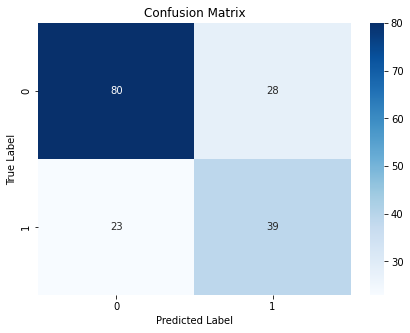

Using Entropy criterion: 

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       108
           1       0.62      0.60      0.61        62

    accuracy                           0.72       170
   macro avg       0.69      0.69      0.69       170
weighted avg       0.72      0.72      0.72       170

Accuracy:        0.7176470588235294
OOS R-square:   -0.21863799283154117
OOS RMSE:        0.5313689313240572


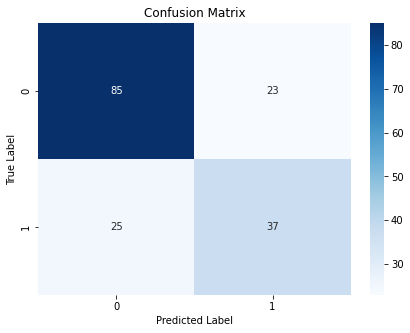

In [22]:
tree_model_gini = tree.DecisionTreeClassifier(criterion="gini", random_state=111)
tree_model_ent = tree.DecisionTreeClassifier(criterion="entropy", random_state=111)

# use the same split datasets as PCA LR
tree_model_gini.fit(X_train, y_train)
tree_model_ent.fit(X_train, y_train)

y_pred_tree_gini = tree_model_gini.predict(X_test)
y_pred_tree_ent = tree_model_ent.predict(X_test)

print("Using Gini criterion: \n")
GetReport(y_test, y_pred_tree_gini)
print("============================================================")
print("Using Entropy criterion: \n")
GetReport(y_test, y_pred_tree_ent)

### <a id='toc1_5_1_'></a>[*Result Analysis:](#toc0_)
| Metric       | Base LR |Tree (Gini)| Tree (Entropy) |
|--------------|---------|----------|-------------|
| Accuracy     | 0.776   | 0.700    | 0.727       |
| OOS R-square | 0.035   | -0.294   | -0.218      |
| OOS RMSE     | 0.472   | 0.547    | 0.531       |

> **Model Performance Comparison:**  
> Comparing Accuracy, OOS R-square, and OOS RMSE, we can see that the prediction performance:  
>> <mark>Base LR **>** Decision Tree (Entropy) **>** Decision Tree (Gini)</mark>
>   - The logistic regression model has outperformed the decision tree models in all three metrics, suggesting it is a better fit for this particular dataset.
>   - The decision tree with entropy performs slightly better than the one with Gini impurity but is still outperformed by the logistic regression model.  

> **Explanation:**   
> 1. The negative R-square values for the tree models indicate the models may be capturing noise rather than the underlying relationship in the data.  
> 2. Decision trees can capture non-linear relationships, but given this dataset, probably linear is better to describe the relationship between X and y.


## <a id='toc1_6_'></a>[5  K Means Clustering using Age and Price](#toc0_)

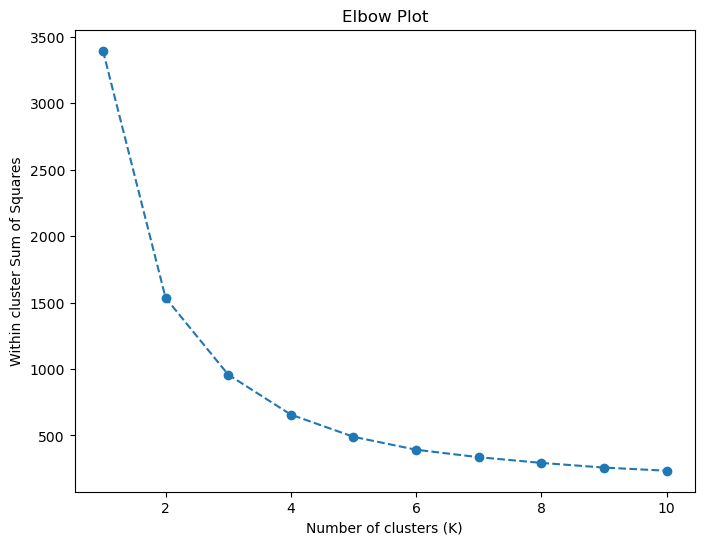

In [132]:
X_2 = X[['Age','Price']]
X_2_scaled = RobustScaler().fit_transform(X_2)

inertia = []

for i in range(1, 11):  # For example, trying K from 1 to 10
    kmeans_model = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_model.fit(X_2_scaled)
    inertia.append(kmeans_model.inertia_)

# Plotting the results onto a line graph to observe 'The Elbow'
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Plot')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within cluster Sum of Squares')
plt.show()

> From the Elbow Plot above, choose K = 3:
>> While the WCSS decreases rapidly from 1 to 3, the rate of decrease lessens after K=3, suggesting that additional clusters do not capture as much additional structure of the data.  
>> Also, fewer clusters can make the model easier to interpret.  
>> Overall, choosing K = 3 strikes a balance between underfitting (too few clusters) and overfitting (too many clusters).

(array([0, 1, 2], dtype=int32), array([129,  34, 686]))


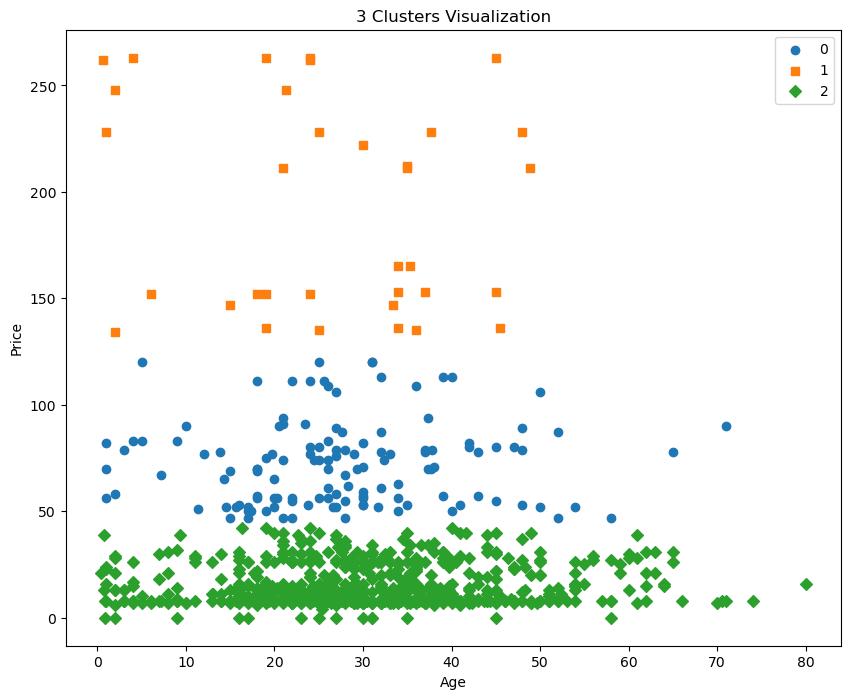

In [153]:
kmeans_model = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_model.fit(X_2_scaled)

# Find cluster labels
labels = kmeans_model.labels_
print(np.unique(labels, return_counts=True))

# Merge with X_2 to visualize the result
kmeans_result = pd.concat([X_2, pd.DataFrame({'cluster':labels})], axis=1)

marker0_ind = kmeans_result[kmeans_result['cluster']==0].index
marker1_ind = kmeans_result[kmeans_result['cluster']==1].index
marker2_ind = kmeans_result[kmeans_result['cluster']==2].index
#marker3_ind = kmeans_result[kmeans_result['cluster']==3].index

plt.figure(figsize=(10, 8))
plt.scatter(x=kmeans_result.loc[marker0_ind,'Age'], y=kmeans_result.loc[marker0_ind,'Price'], marker='o', label = '0')
plt.scatter(x=kmeans_result.loc[marker1_ind,'Age'], y=kmeans_result.loc[marker1_ind,'Price'], marker='s', label = '1')
plt.scatter(x=kmeans_result.loc[marker2_ind,'Age'], y=kmeans_result.loc[marker2_ind,'Price'], marker='D', label = '2')
#plt.scatter(x=kmeans_result.loc[marker2_ind,'Age'], y=kmeans_result.loc[marker2_ind,'Price'], marker='^', label = '3')

plt.xlabel('Age')
plt.ylabel('Price')
plt.title('3 Clusters Visualization')
plt.legend()
plt.show()

#### <a id='toc1_6_1_1_'></a>[*Result Analysis:](#toc0_)

> From the viz above, we can see that the separate line between cluster is almost horizontal, meaning that the clusters are primarily differentiated by 'Price' rather than 'Age':
> Cluster 1 (Orange): high-price group; Cluster 2 (Green): low-price group; Cluster 0 (Blue): the rest of the data, middle-price group.   

> **Possible Reason:**  
>   -  Price as a Stronger Differentiator:Variations in 'Price' lead to more distinct groupings than variations in 'Age'.  

## <a id='toc1_7_'></a>[6  Findings and Conclusions](#toc0_)

### <a id='toc1_7_1_'></a>[1) Entry Prediction](#toc0_)

In [25]:
# Recreate Base Model with full data for coefficients interpretation
df_X_scaled = pd.DataFrame(X_scaled)
df_X_scaled.columns = X.columns
X_sclaed_constant = sm.add_constant(df_X_scaled)

lr_full_model = sm.GLM(y, X_sclaed_constant, family=sm.families.Binomial()).fit()
lr_full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Entry   No. Observations:                  849
Model:                            GLM   Df Residuals:                      842
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -392.82
Date:                Fri, 23 Feb 2024   Deviance:                       785.65
Time:                        13:25:13   Pearson chi2:                     875.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3348
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.2153      0.158    -14.003      0.000      -2.525      -1.905
TicketClass     -0.9827      0.134     -7.319      0.000      -1.246      -0.720
Age              0.1612      0.108      1.492      0.136      -0.051       0.373
Price           -0.0362      0.063     -0.578      0.563      -0.159       0.087
Bank Balance     0.1486      0.146      1.020      0.308      -0.137       0.434
male            -2.8187      0.267    -10.563      0.000      -3.342      -2.296
Miss            -0.2372      0.293     -0.811      0.418      -0.811       0.336
================================================================================
"""

> From the result above:
> - TicketClass and male are significant predictors of the ticket entry being approved or denied  
>> - **TicketClass:** negatively associated with the odds of entry approval. A lower class of ticket (ticket price cheaper) will reduce the log-odds of approval by multipling exp(-0.9827) = 0.374;  
>> - **Male:** significantly decreasing the odds of entry approval, reducing the log-odds of approval by multipling exp(-2.8187) = 0.0596, compared to Female  
> - Other variables (Age, Price, Bank Balance, and Miss) do not have a statistically significant impact on the entry approval based on this model's results.

> **Insights:**   
> - There might exist gender discrimination for ticket entry. Male are less likely to get approved than female according to the model.
> - Higher Ticket Class has higher odds to get approval, indicating that buying better ticket will increase the possibility of ticket getting approved.

### <a id='toc1_7_2_'></a>[2) K-Means Clustering](#toc0_)

From the K-Means clustering result above, we can see that the distribution of 'Age' within clusters is overlapping,  
indicating that 'Age' alone does not create distinct groupings in the data. It implies that customers of nearly all ages are present in each price-based segment.  

> **Insight:**  
>   - For the Event Ticket business, this could inform strategy by highlighting that pricing tiers are more relevant for market segmentation than age groups.  
>   - It suggests tailoring its products to pricing sensitivity rather than the age demographic.